import packages and dataset

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sksurv

from sksurv.ensemble import RandomSurvivalForest
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import OneHotEncoder


df = pd.read_excel("~/Downloads/RADCURE_Clinical_v04_20241219.xlsx")
#print(df.columns)
#print(df.head(5))

#df['Smoking PY'].unique()

Generate Kaplan-Meier curves (2)

(3346, 34)
(75, 34)


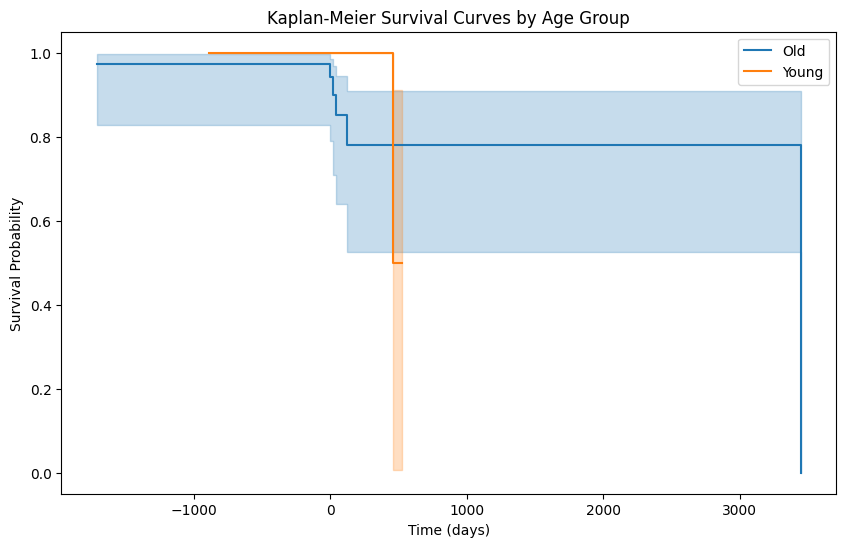

(73, 37)


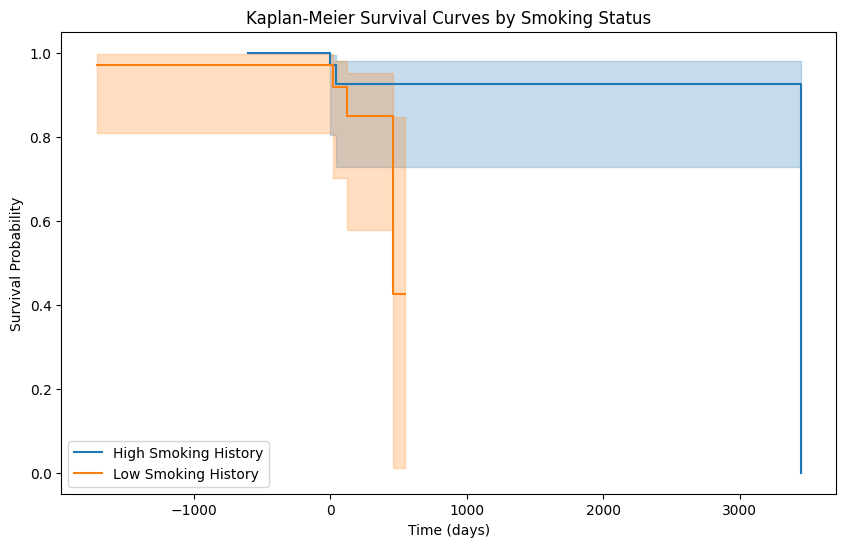

In [184]:
#data cleaning for plot1

print(df.shape)

df = df.dropna(subset="Date Local")
df = df.dropna(subset="Date Distant")
df = df.drop_duplicates()

print(df.shape)

df['Survival Time'] = (df['Date Distant'] - df['Date Local']).dt.days
df['Event'] = np.where(df['2nd Ca'].notnull(), 1, 0)

median_age = df['Age'].median()
df['Age Group'] = np.where(df['Age'] < median_age, 'Young', 'Old')

#graph for age groups young/old
kmf_age = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for group in df['Age Group'].unique():
    group_data = df[df['Age Group'] == group]
    kmf_age.fit(group_data['Survival Time'], event_observed=group_data['Event'], label=group)
    kmf_age.plot()

plt.title('Kaplan-Meier Survival Curves by Age Group')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

#data cleaning for plot2

df = df.dropna(subset="Smoking PY")
df = df[df['Smoking PY'] != 'na']
print(df.shape)

median_smoking = df['Smoking PY'].median()
df['Smoking PY'] = np.where(df['Smoking PY'] < median_smoking, 'Low Smoking History', 'High Smoking History')

#graph for smokers 
kmf_smoking = KaplanMeierFitter()
plt.figure(figsize=(10, 6))

for group in df['Smoking PY'].unique():
    group_data = df[df['Smoking PY'] == group]
    kmf_age.fit(group_data['Survival Time'], event_observed=group_data['Event'], label=group)
    kmf_age.plot()

plt.title('Kaplan-Meier Survival Curves by Smoking Status')
plt.xlabel('Time (days)')
plt.ylabel('Survival Probability')
plt.legend()
plt.show()

Cox regression analysis

In [185]:
df = pd.read_excel("~/Downloads/RADCURE_Clinical_v04_20241219.xlsx")

#data cleaning
df = df.dropna(subset="Date Local")
df = df.dropna(subset="Date Distant")
df = df.drop_duplicates()

df['Survival Time'] = (df['Date Distant'] - df['Date Local']).dt.days
df['Event'] = np.where(df['2nd Ca'].notnull(), 1, 0)

df = df.dropna(subset="Smoking PY")
df = df[df['Smoking PY'] != 'na']

df = df.dropna(subset="Sex")
df = df.drop_duplicates()

df['Sex'] = df['Sex'].map({'Female': 1, 'Male': 0})

#cox
covariates = ['Age', 'Sex', 'Smoking PY']
cox = CoxPHFitter()
cox.fit(df[['Event', 'Survival Time'] + covariates], duration_col='Event', event_col='Survival Time')

cox.print_summary()

#validate cox

cox.check_assumptions(df[['Event', 'Survival Time'] + covariates])


<lifelines.CoxPHFitter: fitted with 73 total observations, 15 right-censored observations>
             duration col = 'Event'
                event col = 'Survival Time'
      baseline estimation = breslow
   number of observations = 73
number of events observed = 58
   partial log-likelihood = -205.63
         time fit was run = 2025-03-15 02:55:07 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
Age        -0.01      0.99      0.01           -0.04            0.01                0.96                1.01
Sex        -0.15      0.86      0.34           -0.83            0.52                0.44                1.69
Smoking PY  0.00      1.00      0.01           -0.01            0.02                0.99                1.02

            cmp to     z    p  -log2(p)
covariate                              
Age           0.00 -0.92 0.36      1.49
Sex           0.00 -0.44 0.66      0.60
Smoking PY    0.00  0.73 0.47      1.09
---
Concordance = 0.63
Partial AIC = 417.26
log-likelihood ratio test = 1.57 on 3 df
-log2(p) of ll-ratio test = 0.58

Proportional hazard assumption looks okay.


[]

Random Survival Forests

In [ ]:
#print(df['Age'])
#print(df['Sex'])
#print(df['Smoking PY'])
#print(df['Event'])
#print(df['Survival Time'])

print(sksurv.__version__)


df = df[df['Survival Time'] >= 0]

X = df[['Age', 'Sex', 'Smoking PY']].values
y = np.array(list(zip(df['Event'], df['Survival Time'])), dtype=[('Event', 'bool'), ('Survival Time', 'float')])

rsf = RandomSurvivalForest(n_estimators=100, random_state=42)
rsf.fit(X, y)

#issue with RandomSurvivalForest

#importances = rsf.feature_importances_
#print(importances)

#rsf_c_index = concordance_index_censored(y['Event'], y['Survival Time'], rsf.predict(X))
#print(rsf_c_index[0])

#cph_c_index = concordance_index_censored(df['Event'], df['Survival Time'], cph.predict(df[['Age', 'Sex', 'Smoking PY']]))
#print(cph_c_index[0])

0.24.0


NotImplementedError: 